In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, show_summaries, get_X
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_sklearn

In [2]:
%%time

cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

for city in cities:
    print(city + '...')
    fig_dir = 'figs/modeling/{}/'.format(city)
    data_dir = 'data/{}/'.format(city)

    dfb = pd.read_pickle(data_dir + 'business.pkl')
    dfu = pd.read_pickle(data_dir + 'user.pkl')

    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

    X_train = get_X(X_train, dfb, dfu)
    X_test = get_X(X_test, dfb, dfu)
    X_cv = get_X(X_cv, dfb, dfu)

    data_split = [X_train, y_train, X_test, y_test, X_cv, y_cv]

    IO(data_dir + '05_data_split.pkl').to_pickle(data_split)

    del dfb
    del dfu
    del data_split
    print(city + ' preprocessing successful.')
    print()
    

Champaign...
Champaign preprocessing successful.

Cleveland...
Cleveland preprocessing successful.

Pittsburgh...
Pittsburgh preprocessing successful.

Toronto...
Toronto preprocessing successful.

Las_Vegas...
Las_Vegas preprocessing successful.

Full...
Full preprocessing successful.

Wall time: 4min 26s


In [2]:
%%time

cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

for city in cities:
    print(city + '...')
    fig_dir = 'figs/modeling/{}/'.format(city)
    data_dir = 'data/{}/'.format(city)
    
    models = [RS_sklearn(RidgeCV()), RS_sklearn(LogisticRegressionCV(class_weight='balanced'))]
    model_names = ['Ridge regression', 'Logistic regression']
    test = [True, True]
    datanames = [data_dir + 'results05/' + str(i) + '.pkl' for i in range(len(models))]

    IO(data_dir + 'results05/models.pkl').to_pickle(models)
    IO(data_dir + 'results05/model_names.pkl').to_pickle(model_names)
    IO(data_dir + 'results05/datanames.pkl').to_pickle(datanames)

Champaign...
Cleveland...
Pittsburgh...
Toronto...
Las_Vegas...
Full...
Wall time: 17 ms


In [3]:
%%time

cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

for city in cities:
    print(city + '...')
    fig_dir = 'figs/modeling/{}/'.format(city)
    data_dir = 'data/{}/'.format(city)

    is_successful = []
    
    datanames = IO(data_dir + 'results05/datanames.pkl').read_pickle()
    models = IO(data_dir + 'results05/models.pkl').read_pickle()
    model_names = IO(data_dir + 'results05/model_names.pkl').read_pickle()
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + '05_data_split.pkl').read_pickle()
    
    for i, model in enumerate(models):
        try:
            print(model_names[i] + '...')
            if not test[i]:
                print('Estimator not tested')
                is_successful.append(False)
                print()
                continue
            model.fit(X_train, y_train)
            print(model_names[i] + ' fitting successful.')
            model.cv_r2 = model.score(X_cv, y_cv, scoring='r2')
            print(model_names[i] + ' cv r2 calculation successful.')
            try:
                IO(datanames[i]).to_pickle(model)
                print('Saving to pickle successful.')
            except:
                traceback.print_exc()
                print('Saving to pickle failed.')
            del model
            is_successful.append(True)
            print()
        except:
            traceback.print_exc()
            print(model_names[i] + ' failed.')
            is_successful.append(False)
            print()

    IO(data_dir + 'results05/is_successful.pkl').to_pickle(is_successful)

Champaign...
Ridge regression...
Ridge regression fitting successful.
Ridge regression cv r2 calculation successful.
Saving to pickle successful.

Logistic regression...
Logistic regression fitting successful.
Logistic regression cv r2 calculation successful.
Saving to pickle successful.

Cleveland...
Ridge regression...
Ridge regression fitting successful.
Ridge regression cv r2 calculation successful.
Saving to pickle successful.

Logistic regression...
Logistic regression fitting successful.
Logistic regression cv r2 calculation successful.
Saving to pickle successful.

Pittsburgh...
Ridge regression...
Ridge regression fitting successful.
Ridge regression cv r2 calculation successful.
Saving to pickle successful.

Logistic regression...
Logistic regression fitting successful.
Logistic regression cv r2 calculation successful.
Saving to pickle successful.

Toronto...
Ridge regression...
Ridge regression fitting successful.
Ridge regression cv r2 calculation successful.
Saving to pick

In [4]:
%%time

cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

for city in cities:
    print(city + '...')
    fig_dir = 'figs/modeling/{}/'.format(city)
    data_dir = 'data/{}/'.format(city)

    is_successful = IO(data_dir + 'results05/is_successful.pkl').read_pickle()
    datanames = IO(data_dir + 'results05/datanames.pkl').read_pickle()
    model_names = IO(data_dir + 'results05/model_names.pkl').read_pickle()
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + '05_data_split.pkl').read_pickle()

    results = []
    for i in range(len(is_successful)):
        print(model_names[i] + '...')
        if not is_successful[i]:
            results.append(None)
        else:
            model = IO(datanames[i]).read_pickle()
            results.append(get_results(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
                                       X_cv=X_cv, y_cv=y_cv))
            del model
        
    print('Done.')
    IO(data_dir + 'results05/results.pkl').to_pickle(results)
    print()

Champaign...
Ridge regression...
Logistic regression...
Done.

Cleveland...
Ridge regression...
Logistic regression...
Done.

Pittsburgh...
Ridge regression...
Logistic regression...
Done.

Toronto...
Ridge regression...
Logistic regression...
Done.

Las_Vegas...
Ridge regression...
Logistic regression...
Done.

Full...
Ridge regression...
Logistic regression...
Done.

Wall time: 14.3 s


In [5]:
%%time

cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

for city in cities:
    print(city + '...')
    fig_dir = 'figs/modeling/{}/'.format(city)
    data_dir = 'data/{}/'.format(city)
    model_names = IO(data_dir + 'results05/model_names.pkl').read_pickle()
    results = IO(data_dir + 'results05/results.pkl').read_pickle()
    is_successful = IO(data_dir + 'results05/is_successful.pkl').read_pickle()
    sizes = IO(data_dir + 'sizes.pkl').read_pickle()

    display(Markdown('## {} <sup>({} reviews, {} restaurants, {} users)</sup>'.\
                     format(city, sizes[0], sizes[1], sizes[2])))
    display(Markdown('**Content filtering**'))
    show_summaries(model_names, results, is_successful)


Champaign...


## Champaign <sup>(20571 reviews, 878 restaurants, 8451 users)</sup>

**Content filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,0.0670,1.0773,1.0971,0.4339,0.4280
Logistic regression,2.6342,1.3972,1.4177,0.0479,0.0449


Cleveland...


## Cleveland <sup>(75932 reviews, 2500 restaurants, 30131 users)</sup>

**Content filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,0.2770,1.0195,1.0313,0.4251,0.4141
Logistic regression,6.4314,1.3448,1.3663,-0.0004,-0.0284


Pittsburgh...


## Pittsburgh <sup>(143682 reviews, 4745 restaurants, 46179 users)</sup>

**Content filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,0.5090,1.0158,1.0062,0.4135,0.4245
Logistic regression,11.1896,1.3585,1.3511,-0.0488,-0.0376


Toronto...


## Toronto <sup>(331407 reviews, 12118 restaurants, 77506 users)</sup>

**Content filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,1.2151,1.0049,1.0035,0.3970,0.3955
Logistic regression,31.0728,1.3890,1.3901,-0.1521,-0.1600


Las_Vegas...


## Las_Vegas <sup>(1280896 reviews, 20434 restaurants, 429363 users)</sup>

**Content filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,4.4893,1.1216,1.1226,0.3923,0.3911
Logistic regression,116.0756,1.4512,1.4549,-0.0173,-0.0228


Full...


## Full <sup>(4166778 reviews, 131025 restaurants, 1117891 users)</sup>

**Content filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,18.8461,1.0857,1.0869,0.4171,0.4167
Logistic regression,303.0803,1.4006,1.4002,0.0300,0.0319


Wall time: 187 ms


Champaign...


### Ridge regression

Fitting time: 0.0670 s.  
            RMSE on training set: 1.0773.  
            RMSE on test set: 1.0971.  
            $R^2$ on training set: 0.4339.  
            $R^2$ on cross-validation set: 0.4164.  
            $R^2$ on test set: 0.4280.  
            Classification accuracy on training set: 0.3822.  
            Classification accuracy on test set: 0.3935.
            

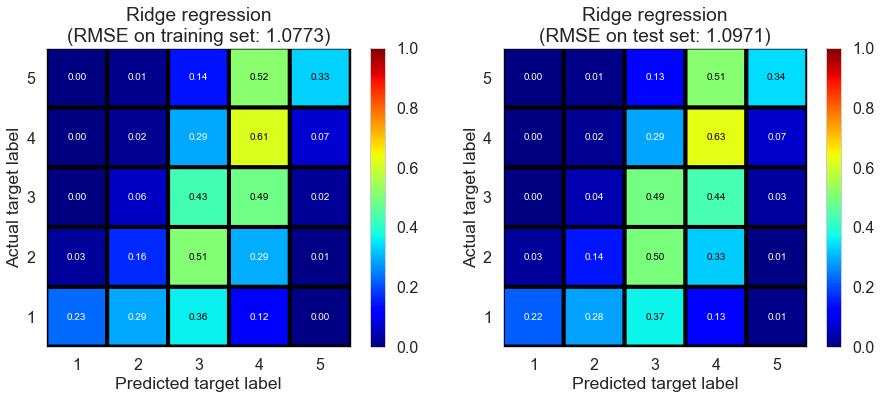

### Logistic regression

Fitting time: 2.6342 s.  
            RMSE on training set: 1.3972.  
            RMSE on test set: 1.4177.  
            $R^2$ on training set: 0.0479.  
            $R^2$ on cross-validation set: 0.0142.  
            $R^2$ on test set: 0.0449.  
            Classification accuracy on training set: 0.4805.  
            Classification accuracy on test set: 0.4735.
            

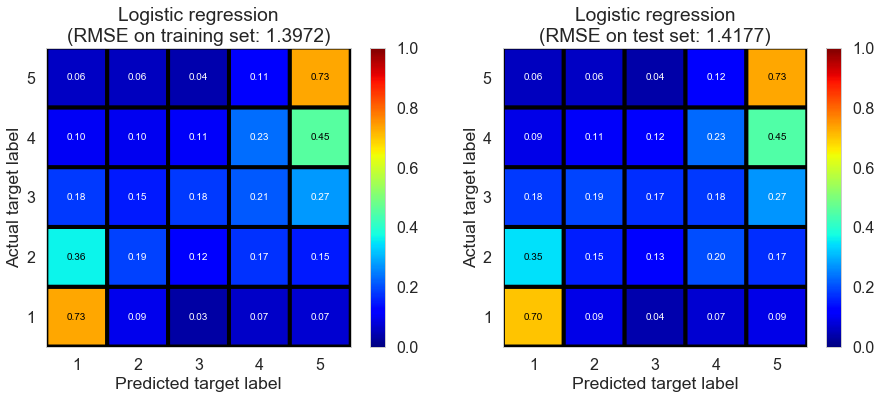


Cleveland...


### Ridge regression

Fitting time: 0.2770 s.  
            RMSE on training set: 1.0195.  
            RMSE on test set: 1.0313.  
            $R^2$ on training set: 0.4251.  
            $R^2$ on cross-validation set: 0.4124.  
            $R^2$ on test set: 0.4141.  
            Classification accuracy on training set: 0.4152.  
            Classification accuracy on test set: 0.4115.
            

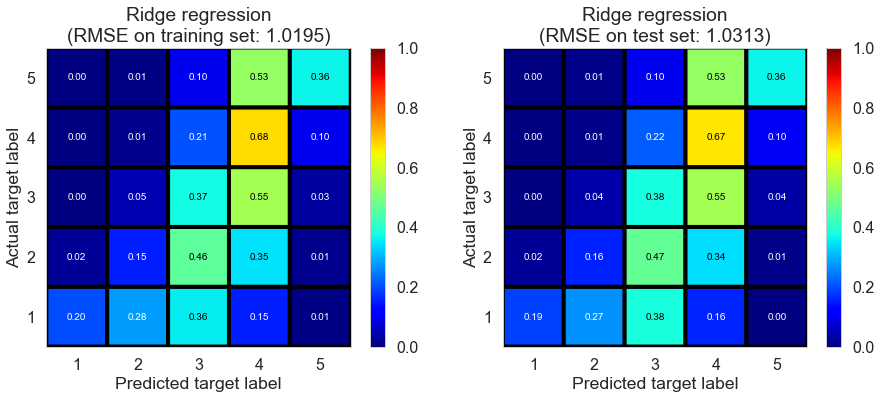

### Logistic regression

Fitting time: 6.4314 s.  
            RMSE on training set: 1.3448.  
            RMSE on test set: 1.3663.  
            $R^2$ on training set: -0.0004.  
            $R^2$ on cross-validation set: -0.0222.  
            $R^2$ on test set: -0.0284.  
            Classification accuracy on training set: 0.4761.  
            Classification accuracy on test set: 0.4706.
            

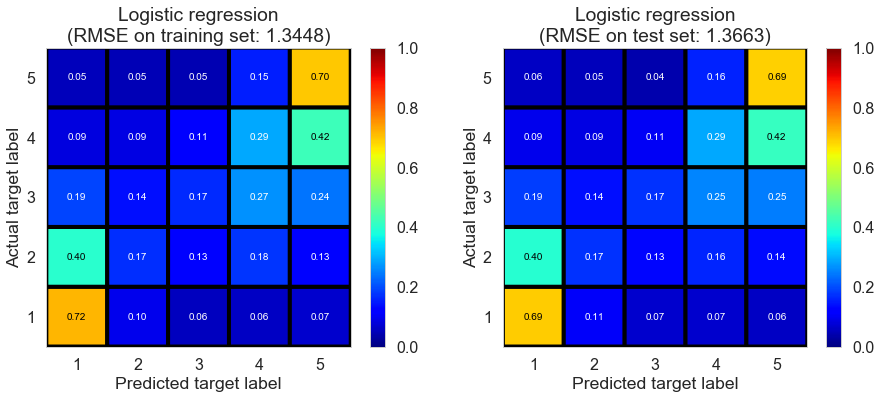


Pittsburgh...


### Ridge regression

Fitting time: 0.5090 s.  
            RMSE on training set: 1.0158.  
            RMSE on test set: 1.0062.  
            $R^2$ on training set: 0.4135.  
            $R^2$ on cross-validation set: 0.4187.  
            $R^2$ on test set: 0.4245.  
            Classification accuracy on training set: 0.4226.  
            Classification accuracy on test set: 0.4245.
            

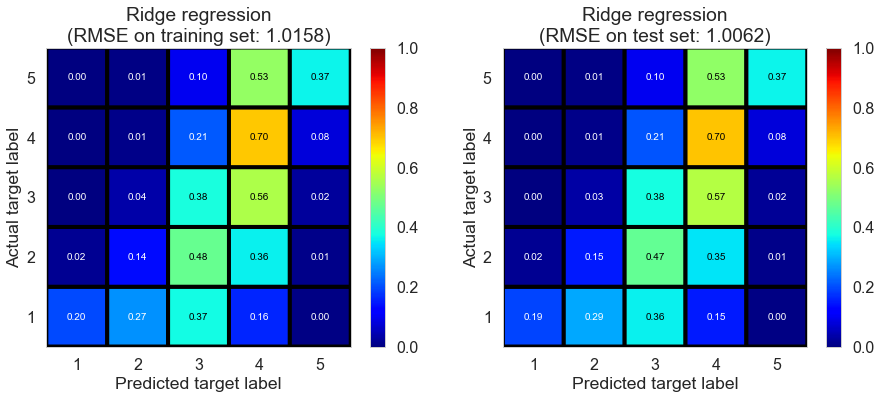

### Logistic regression

Fitting time: 11.1896 s.  
            RMSE on training set: 1.3585.  
            RMSE on test set: 1.3511.  
            $R^2$ on training set: -0.0488.  
            $R^2$ on cross-validation set: -0.0412.  
            $R^2$ on test set: -0.0376.  
            Classification accuracy on training set: 0.4613.  
            Classification accuracy on test set: 0.4643.
            

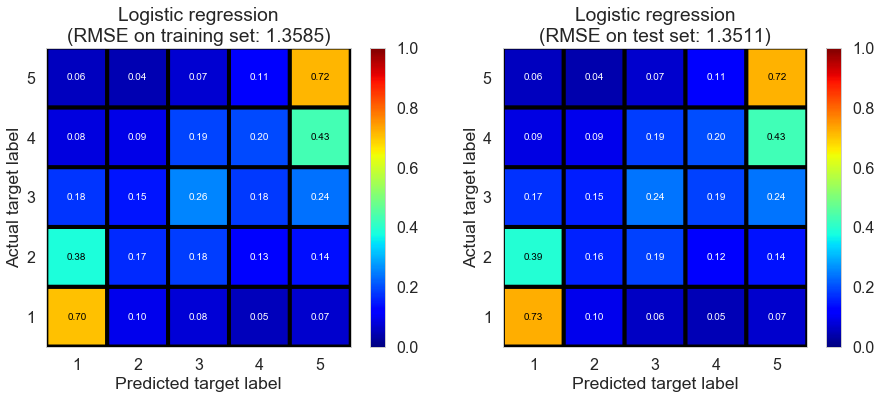


Toronto...


### Ridge regression

Fitting time: 1.2151 s.  
            RMSE on training set: 1.0049.  
            RMSE on test set: 1.0035.  
            $R^2$ on training set: 0.3970.  
            $R^2$ on cross-validation set: 0.3933.  
            $R^2$ on test set: 0.3955.  
            Classification accuracy on training set: 0.4137.  
            Classification accuracy on test set: 0.4186.
            

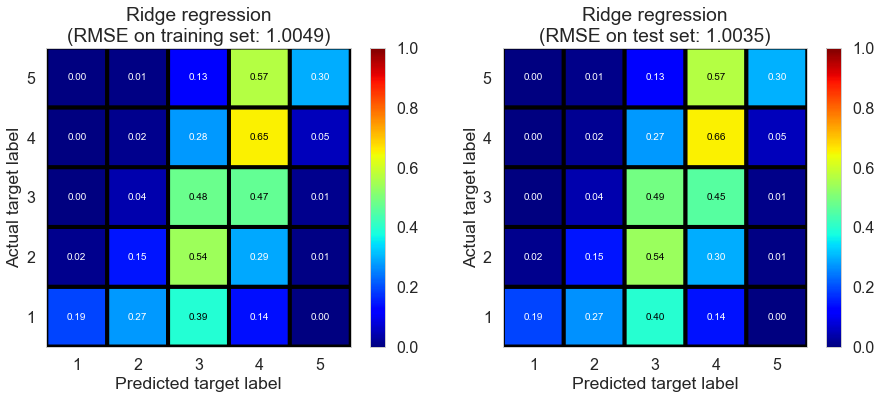

### Logistic regression

Fitting time: 31.0728 s.  
            RMSE on training set: 1.3890.  
            RMSE on test set: 1.3901.  
            $R^2$ on training set: -0.1521.  
            $R^2$ on cross-validation set: -0.1714.  
            $R^2$ on test set: -0.1600.  
            Classification accuracy on training set: 0.4177.  
            Classification accuracy on test set: 0.4170.
            

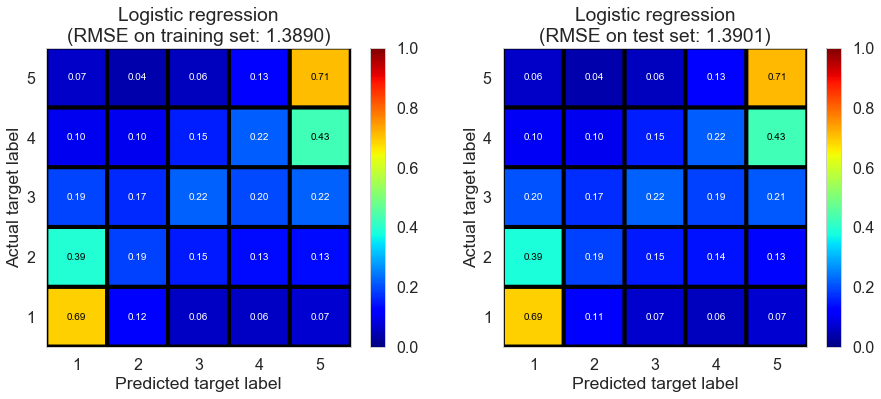


Las_Vegas...


### Ridge regression

Fitting time: 4.4893 s.  
            RMSE on training set: 1.1216.  
            RMSE on test set: 1.1226.  
            $R^2$ on training set: 0.3923.  
            $R^2$ on cross-validation set: 0.3918.  
            $R^2$ on test set: 0.3911.  
            Classification accuracy on training set: 0.3854.  
            Classification accuracy on test set: 0.3847.
            

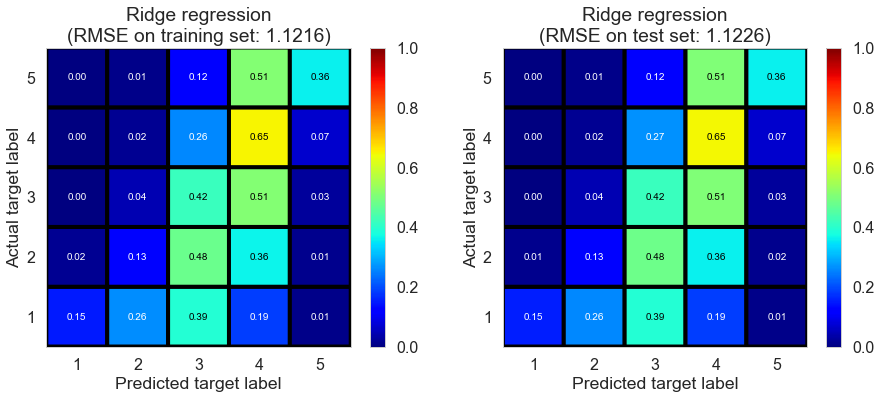

### Logistic regression

Fitting time: 116.0756 s.  
            RMSE on training set: 1.4512.  
            RMSE on test set: 1.4549.  
            $R^2$ on training set: -0.0173.  
            $R^2$ on cross-validation set: -0.0166.  
            $R^2$ on test set: -0.0228.  
            Classification accuracy on training set: 0.4988.  
            Classification accuracy on test set: 0.4975.
            

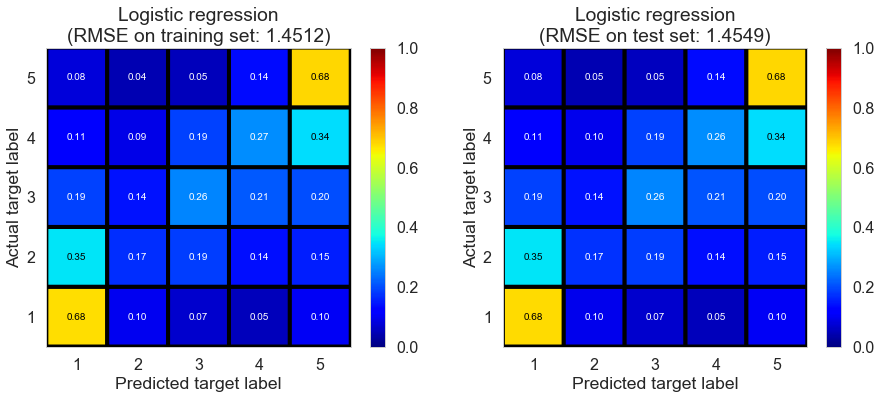


Full...


### Ridge regression

Fitting time: 18.8461 s.  
            RMSE on training set: 1.0857.  
            RMSE on test set: 1.0869.  
            $R^2$ on training set: 0.4171.  
            $R^2$ on cross-validation set: 0.4177.  
            $R^2$ on test set: 0.4167.  
            Classification accuracy on training set: 0.4026.  
            Classification accuracy on test set: 0.4021.
            

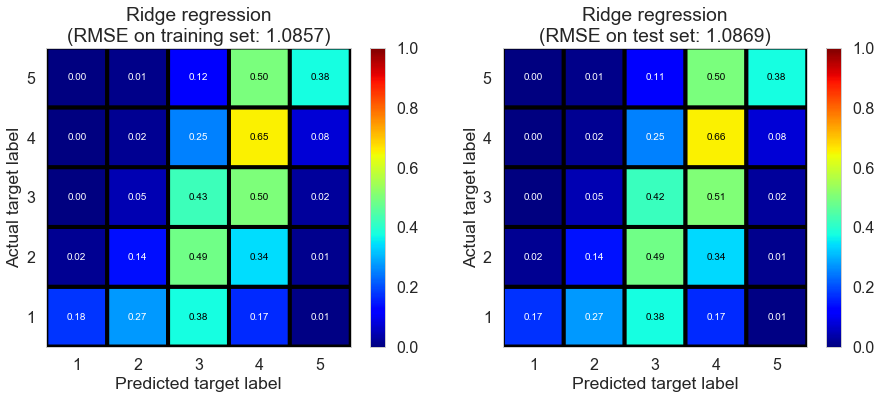

### Logistic regression

Fitting time: 303.0803 s.  
            RMSE on training set: 1.4006.  
            RMSE on test set: 1.4002.  
            $R^2$ on training set: 0.0300.  
            $R^2$ on cross-validation set: 0.0301.  
            $R^2$ on test set: 0.0319.  
            Classification accuracy on training set: 0.4961.  
            Classification accuracy on test set: 0.4957.
            

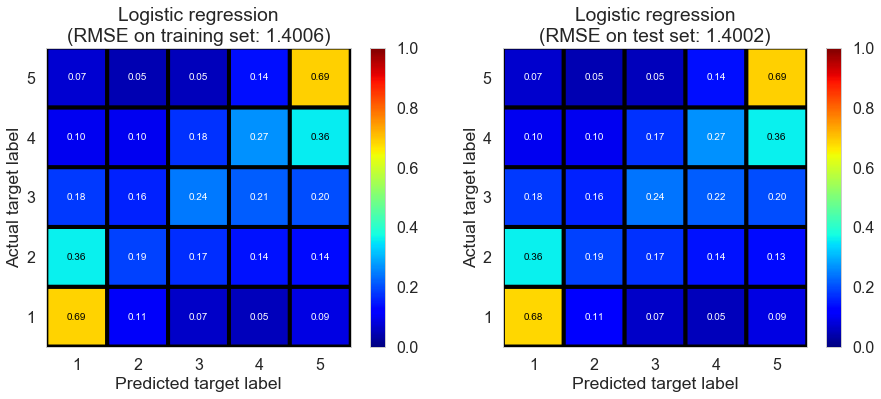


Wall time: 16 s


In [7]:
%%time

cities = ['Champaign', 'Cleveland', 'Pittsburgh', 'Toronto', 'Las_Vegas', 'Full']

for city in cities:
    print(city + '...')
    fig_dir = 'figs/modeling/{}/'.format(city)
    data_dir = 'data/{}/'.format(city)

    is_successful = IO(data_dir + 'results05/is_successful.pkl').read_pickle()
    datanames = IO(data_dir + 'results05/datanames.pkl').read_pickle()
    model_names = IO(data_dir + 'results05/model_names.pkl').read_pickle()
    results = IO(data_dir + 'results05/results.pkl').read_pickle()
    X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + '05_data_split.pkl').read_pickle()

    for i in range(len(is_successful)):
        if is_successful[i]:
            model = IO(datanames[i]).read_pickle()
            show_results(model, model_names[i], X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
                         results=results[i], show_cv=True)
            del model